# **RNN Introduction**


## Importing required libraries


In [1]:
!pip install mplfinance
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 945.2 kB/s eta 0:00:00


In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [17]:
# Reading our dataset
df = pd.read_csv('/content/traffic (1).csv')

In [16]:
# Selecting any random junction out of our 'Junction' column
junction = random.choice(df['Junction'].unique().tolist())

# Setting the start and end date
start_date = dt.datetime(2014,1,1)
end_date = dt.datetime(2020,1,1)


KeyError: 'DateTime'

## Visualization

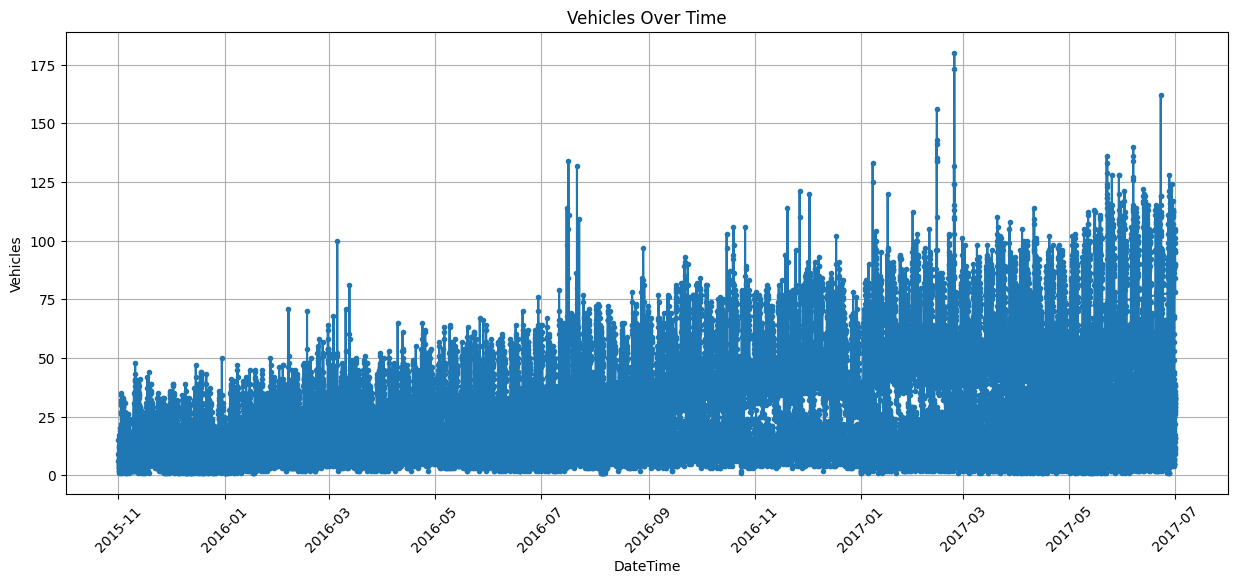

In [18]:
# Line Chart of Closing Prices Over Time

# Convert 'DateTime' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

plt.figure(figsize=(15, 6))
plt.plot(df['DateTime'], df['Vehicles'], marker='.')
plt.title('Vehicles Over Time')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Split the data into train and test

In [22]:
new_df = df.reset_index()['Vehicles']

In [23]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [24]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

## Modeling


In [25]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [26]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(38436, 60)
(38436,)


Testing set size:-
(9564, 60)
(9564,)


(None, None)

In [27]:
# Reshape input data for RNN([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [28]:
# Initialize a sequential model
model = Sequential()

# First RNN layer with 50 units, input shape, and return sequences
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second RNN layer with 50 units and return sequences
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third RNN layer with 50 units
model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our RNN model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=50,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - loss: 9.2974e-04 - val_loss: 8.8240e-04
Epoch 2/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - loss: 8.5187e-04 - val_loss: 8.0985e-04
Epoch 3/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 8.2909e-04 - val_loss: 8.1775e-04
Epoch 4/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - loss: 8.1399e-04 - val_loss: 8.7688e-04
Epoch 5/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - loss: 8.1839e-04 - val_loss: 0.0011
Epoch 6/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 8.2986e-04 - val_loss: 8.0992e-04
Epoch 7/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - loss: 8.0919e-04 - val_loss: 8.3876e-04
Epoch 8/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 63s 52ms/step - loss: 8.0806e-04 - val_loss: 0.0011
Epoch 9/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - loss: 8.5529e-04 - val_loss: 8.9917e-04
Epoch 10/50
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - loss: 8.8628e-04 - val_loss: 8.6856e-04
Epoch 11/50
1202/1202 ━━━━━

In [32]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

1202/1202 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [33]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [34]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

31.653089962626844
15.188409594369041


## Visualization of results


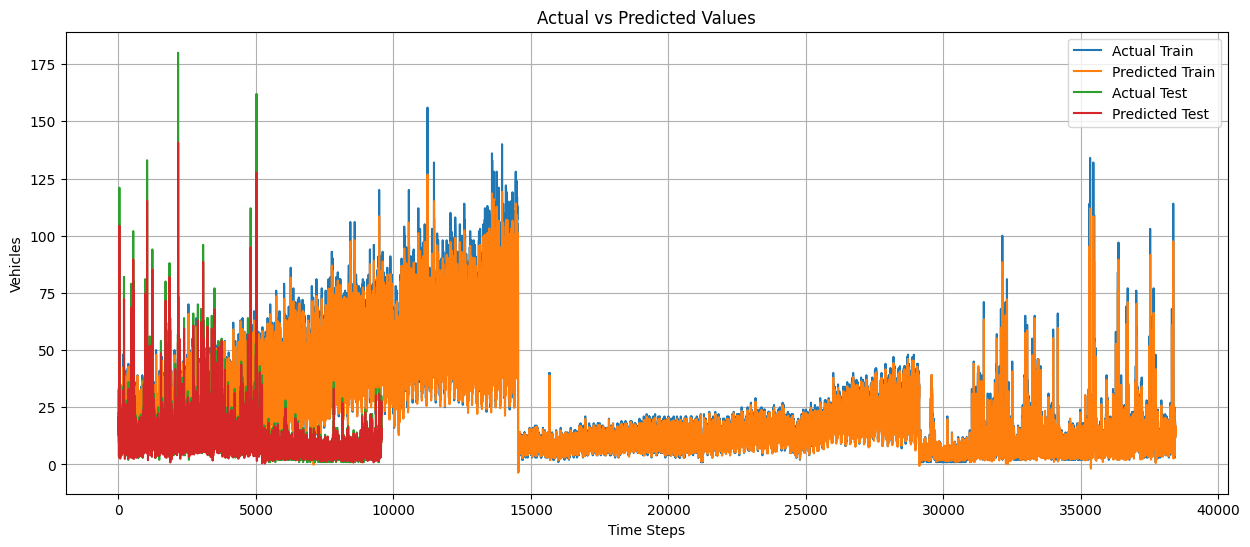

In [40]:
# Get actual values in original scale
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_train_original, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')
plt.plot(y_test_original, label='Actual Test')
plt.plot(test_predict, label='Predicted Test')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Vehicles')
plt.legend()
plt.grid(True)
plt.show()